## Seaborn Plots with Diabetes by Race

#### Import Boiler Plate Modules:

In [3]:
# This line configures matplotlib to show figures embedded in the notebook.
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Data from source U.S. Chronic Disease: https://www.cdc.gov/cdi/index.html

In [4]:
usecols = ['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType',
       'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol',
       'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
       'StratificationCategory1', 'Stratification1', 
       'GeoLocation', 'LocationID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1' ]

df = pd.read_csv("U.S._Chronic_Disease_Indicators__CDI_.csv", 
                 usecols=usecols, dtype={'DataValue': 'object',})
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,US,United States,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,16.9,...,18.0,Overall,Overall,NaN,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,AL,Alabama,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,13.0,...,14.1,Overall,Overall,"(32.84057112200048, -86.63186076199969)",1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,AK,Alaska,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,18.2,...,20.6,Overall,Overall,"(64.84507995700051, -147.72205903599973)",2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,AZ,Arizona,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.6,...,16.9,Overall,Overall,"(34.865970280000454, -111.76381127699972)",4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,AR,Arkansas,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.0,...,17.2,Overall,Overall,"(34.74865012400045, -92.27449074299966)",5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


#### A lot of info is duplicated between rows, lets pull those out and turn that data into look up tables (we will keep the ID for each table in the df, so we can merge it back)

In [5]:
# Extract location-related attributes into a location table.
dfLocs = df[['LocationAbbr', 'LocationDesc', 'GeoLocation', 'LocationID']]\
            .set_index('LocationID').groupby('LocationID').first()
geoloc = dfLocs['GeoLocation'].str[1:-1].str.split(',', expand = True).astype('float')
geoloc.columns = ['Latitude', 'Longitude']
dfLocs = pd.concat([geoloc, dfLocs], axis = 1).drop('GeoLocation', axis = 1)
dfLocs.head()


,Latitude,Longitude,LocationAbbr,LocationDesc
LocationID,,,,
1,32.840571,-86.631861,AL,Alabama
2,64.845080,-147.722059,AK,Alaska
4,34.865970,-111.763811,AZ,Arizona
5,34.748650,-92.274491,AR,Arkansas
6,37.638640,-121.000000,CA,California


In [6]:
# Extract topic attributes into a topic table.
dfTopics = df[['TopicID', 'Topic']].groupby('TopicID').first()
dfTopics.head()

,Topic
TopicID,
ALC,Alcohol
ART,Arthritis
AST,Asthma
CAN,Cancer
CKD,Chronic Kidney Disease


In [7]:
# Extract question attributes into a question table.
dfQuestions = df[['QuestionID', 'Question']].groupby('QuestionID').first()
dfQuestions.head()

,Question
QuestionID,
ALC10_0,Local authority to regulate alcohol outlet den...
ALC1_1,Alcohol use among youth
ALC1_2,Alcohol use before pregnancy
ALC2_1,Binge drinking prevalence among youth
ALC2_2,Binge drinking prevalence among adults aged >=...


In [8]:
# Extract Stratification attributes into a Stratification table.
dfStrats = df[['StratificationID1', 'Stratification1']].groupby('StratificationID1').first()
dfStrats

,Stratification1
StratificationID1,
AIAN,American Indian or Alaska Native
API,Asian or Pacific Islander
ASN,"Asian, non-Hispanic"
BLK,"Black, non-Hispanic"
GENF,Female
GENM,Male
HIS,Hispanic
MRC,"Multiracial, non-Hispanic"
OTH,"Other, non-Hispanic"


In [9]:
# Extract StratificationCategory attributes into a StratificationCategory table.
dfStratCats = df[['StratificationCategoryID1', 'StratificationCategory1']] \
    .groupby('StratificationCategoryID1').first()
dfStratCats

,StratificationCategory1
StratificationCategoryID1,
GENDER,Gender
OVERALL,Overall
RACE,Race/Ethnicity


In [10]:
# Extract DataValueType attributes into a DataValueType table.
dfDataValueTypes = df[['DataValueTypeID', 'DataValueType', 'DataValueUnit']]\
    .groupby('DataValueTypeID').first()
dfDataValueTypes.head()

,DataValueType,DataValueUnit
DataValueTypeID,,
AgeAdjMean,Age-adjusted Mean,Number
AgeAdjPrev,Age-adjusted Prevalence,%
AgeAdjRate,Age-adjusted Rate,"cases per 10,000"
AgeSexRaceAdjRate,"Adjusted by age, sex, race and ethnicity","cases per 1,000,000"
AvgAnnAgeAdjRate,Average Annual Age-adjusted Rate,"per 100,000"


#### Now that we have "de-melted" the original data, we will drop all of the duplicate columns into a simpler dataframe using ID's and lookup tables

In [11]:
dfData = df.drop(['GeoLocation', 'LocationAbbr', 'LocationDesc', 'Topic', 'Question', 
    'Stratification1', 'StratificationCategory1', 'DataValueType', 'DataValueUnit'], axis=1)
dfData.head()

,YearStart,YearEnd,DataSource,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,BRFSS,16.9,16.9,*,50 States + DC: US Median,16.0,18.0,59,ALC,ALC2_2,CrdPrev,OVERALL,OVR
1,2016,2016,BRFSS,13.0,13.0,NaN,NaN,11.9,14.1,1,ALC,ALC2_2,CrdPrev,OVERALL,OVR
2,2016,2016,BRFSS,18.2,18.2,NaN,NaN,16.0,20.6,2,ALC,ALC2_2,CrdPrev,OVERALL,OVR
3,2016,2016,BRFSS,15.6,15.6,NaN,NaN,14.3,16.9,4,ALC,ALC2_2,CrdPrev,OVERALL,OVR
4,2016,2016,BRFSS,15.0,15.0,NaN,NaN,13.0,17.2,5,ALC,ALC2_2,CrdPrev,OVERALL,OVR


## First: A little description of what each variable means in the context of this dataset

### This is the response variable (`y`):

<img src="I10Course.png" title="Indicator 10" />

### These are the predicting variables ($X_1$, $X_2$, and $X_3$):

<img src="I5Podi.png" title="Indicator 5" />

<img src="I7Opto.png" title="Indicator 7" />

#### This data was sparse, lots of missing data so we removed it in the end

<img src="I8Dentist.png" title="Indicator 8" />

### Drilling into Diabetes Topic and Selecting Racial Data for Analysis


In [14]:
dfRace = dfData[(dfData['TopicID'] == 'DIA') & #Select Diabetes
      (dfData['DataValueTypeID'] == 'CrdPrev') & #Select Crude Prevalence
      (dfData['DataValueAlt']).notnull() & #Remove null values
      (dfData['StratificationCategoryID1'] == "RACE")] #Overall includes all demographics
pivot_index = ['TopicID', 'YearStart', 'YearEnd', 'LocationID', 'StratificationID1']
dfRace = pd.pivot_table(dfRace, index = pivot_index, columns = 'QuestionID', 
                           values = 'DataValueAlt').reset_index()
dfRace.tail()

QuestionID,TopicID,YearStart,YearEnd,LocationID,StratificationID1,DIA10_0,DIA11_1,DIA11_2,DIA11_3,DIA12_1,DIA12_2,DIA13_1,DIA13_2,DIA2_1,DIA2_2,DIA5_0,DIA6_0,DIA7_0,DIA8_0
1087,DIA,2016,2016,66,MRC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.4,NaN,NaN,NaN,NaN,NaN
1088,DIA,2016,2016,66,OTH,33.5,NaN,NaN,12.0,36.7,65.5,46.4,NaN,10.6,6.5,63.1,54.1,45.6,44.3
1089,DIA,2016,2016,72,HIS,24.5,NaN,NaN,27.6,29.0,48.0,16.1,32.2,15.3,4.7,46.0,74.2,60.9,61.2
1090,DIA,2016,2016,78,BLK,37.9,NaN,NaN,NaN,NaN,31.7,31.3,46.0,14.4,NaN,68.6,62.6,53.5,36.3
1091,DIA,2016,2016,78,HIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN


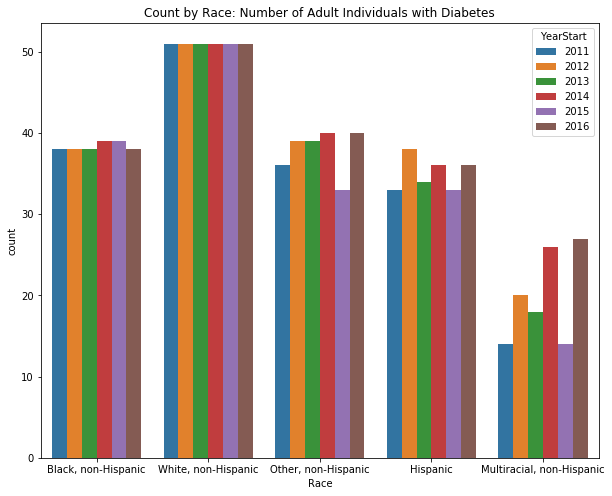

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
dfRaceID = dfRace.merge(dfStrats, left_on = 'StratificationID1', right_index = True)
sns.countplot(x="Stratification1", data=dfRaceID, hue = 'YearStart')
plt.xlabel("Race")
plt.title('Count by Race: Number of Adult Individuals with Diabetes')
plt.savefig('CountbyRace.png')


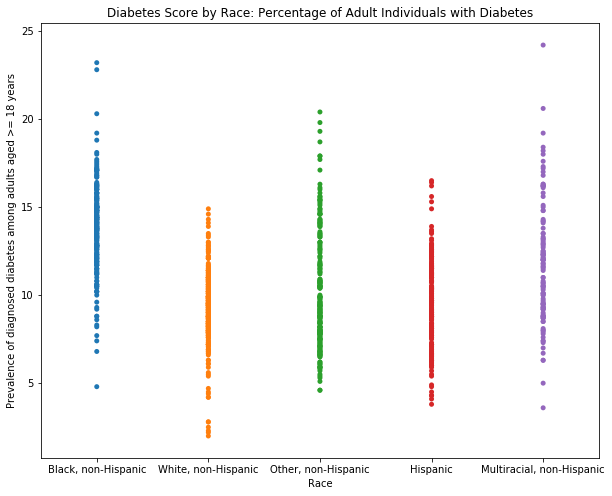

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
sns.stripplot(x="Stratification1", y="DIA2_1", data=dfRaceID)
plt.xlabel("Race")
plt.ylabel(dfQuestions.loc['DIA2_1', 'Question'])
plt.title('Diabetes Score by Race: Percentage of Adult Individuals with Diabetes')
plt.savefig('StripbyRace.png')

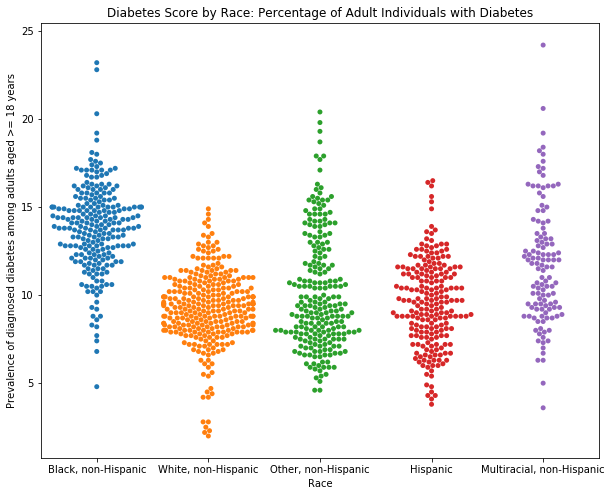

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
sns.swarmplot(x="Stratification1", y="DIA2_1", data=dfRaceID)
plt.xlabel("Race")
plt.ylabel(dfQuestions.loc['DIA2_1', 'Question'])
plt.title('Diabetes Score by Race: Percentage of Adult Individuals with Diabetes')
plt.savefig('SwarmbyRace.png')

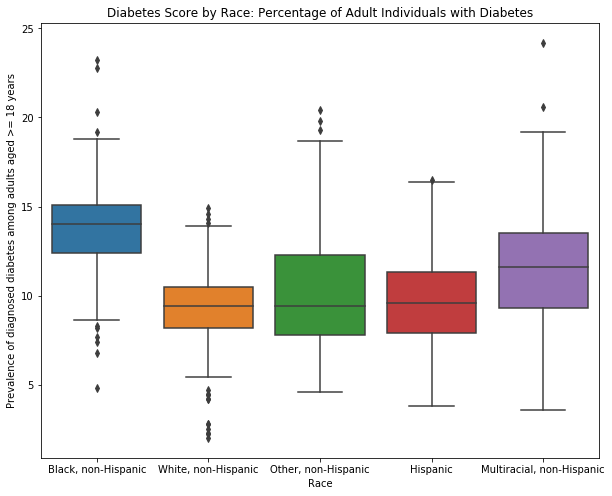

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x="Stratification1", y="DIA2_1", data=dfRaceID)
plt.xlabel("Race")
plt.ylabel(dfQuestions.loc['DIA2_1', 'Question'])
plt.title('Diabetes Score by Race: Percentage of Adult Individuals with Diabetes')
plt.savefig('BoxbyRace.png')

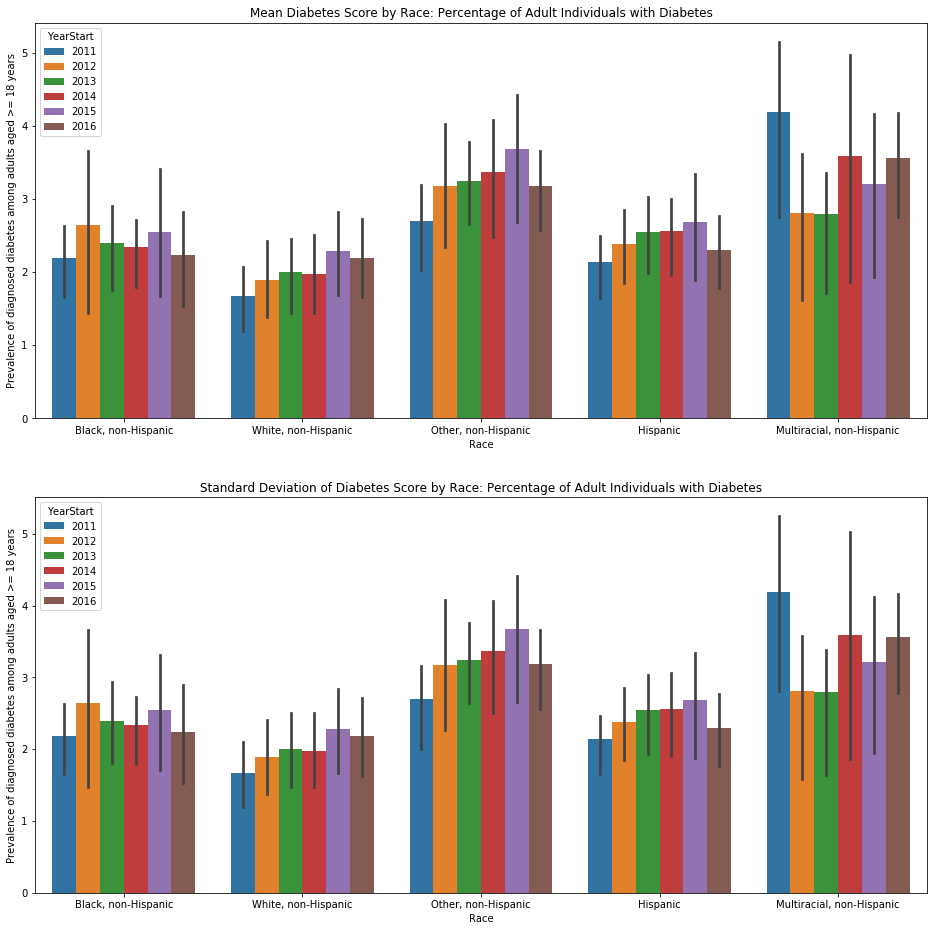

In [41]:
fig, ax = plt.subplots(figsize=(16,16))

plt.subplot(2, 1, 1)
sns.barplot(x="Stratification1", y="DIA2_1", data=dfRaceID, hue = 'YearStart', estimator=np.std)
plt.xlabel("Race")
plt.ylabel(dfQuestions.loc['DIA2_1', 'Question'])
plt.title('Mean Diabetes Score by Race: Percentage of Adult Individuals with Diabetes')

plt.subplot(2, 1, 2)
sns.barplot(x="Stratification1", y="DIA2_1", data=dfRaceID, hue = 'YearStart', estimator=np.std)
plt.xlabel("Race")
plt.ylabel(dfQuestions.loc['DIA2_1', 'Question'])
plt.title('Standard Deviation of Diabetes Score by Race: Percentage of Adult Individuals with Diabetes')

plt.savefig('BarsbyRace.png')